<h1>Training the custom plant disease detection model</h1>

Import all the Dependencies

In [12]:
import numpy as np
import os
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from torchvision.datasets import DatasetFolder

Set all the Constants

In [ ]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 30
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = r'' #path to the downloaded plantvillage dataset's color folder
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

Initializing, Exploring & Partioning the Dataset
Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training
Validation: Dataset to be tested against while training
Test: Dataset to be tested against after we trained a model

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

Reading and Partitioning the Dataset

In [14]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 5738 files belonging to 38 classes.


Checking the Available Classes

In [15]:
# Call the find_classes method to get the classes and class-to-index mapping
classes, class_to_idx = DatasetFolder.find_classes(self=DatasetFolder,directory=data_dir)
n_classes = len(classes)
print(n_classes, classes)

38 ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target

Displaying Some Sample Images

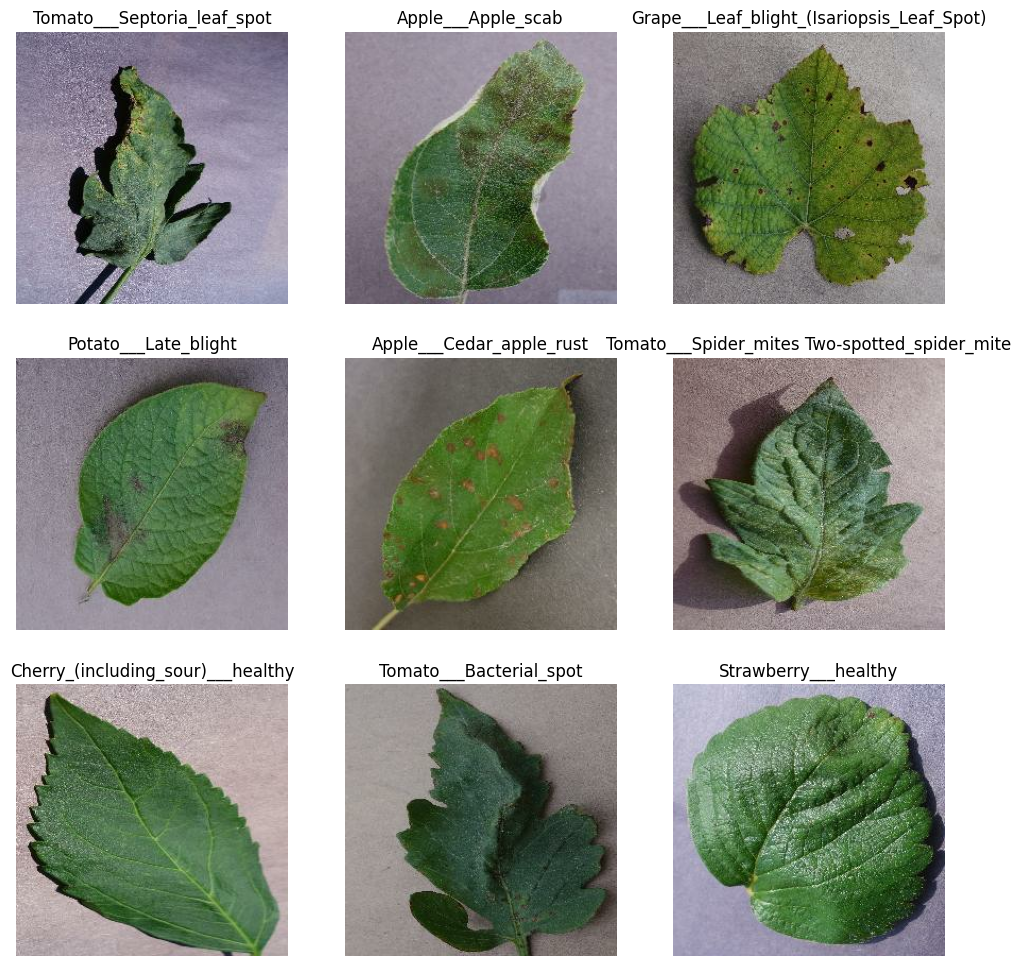

In [25]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

Checking Batch Size

In [26]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


Cache, Shuffle, and Prefetch the Dataset

In [27]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

Building the Model

In [28]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation

In [29]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Checking what is the expected dimension order for channel

In [30]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

Model Architecture

In [31]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

Model Summary

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

Compiling the Model

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Training the Network

In [35]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    #verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
144/144 [==============================] - 1522s 8s/step - loss: 3.6379 - accuracy: 0.0244 - val_loss: 3.6239 - val_accuracy: 0.0382
Epoch 2/30
144/144 [==============================] - 567s 4s/step - loss: 3.6053 - accuracy: 0.0310 - val_loss: 3.5430 - val_accuracy: 0.0365
Epoch 3/30
144/144 [==============================] - 434s 3s/step - loss: 3.4497 - accuracy: 0.0565 - val_loss: 3.2990 - val_accuracy: 0.0677
Epoch 4/30
144/144 [==============================] - 1123s 8s/step - loss: 3.1461 - accuracy: 0.1191 - val_loss: 3.0253 - val_accuracy: 0.1146
Epoch 5/30
144/144 [==============================] - 575s 4s/step - loss: 2.6572 - accuracy: 0.2340 - val_loss: 2.3466 - val_accuracy: 0.2969
Epoch 6/30
144/144 [==============================] - 438s 3s/step - loss: 2.2083 - accuracy: 0.3323 - val_loss: 1.9760 - val_accuracy: 0.3906
Epoch 7/30
144/144 [==============================] - 449s 3s/step - loss: 1.8812 - accuracy: 0.4259 - val_loss: 1.8940 - val_accuracy: 0.42

Testing the Model

In [36]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
18/18 [==============================] - 364s 3s/step - loss: 0.6358 - accuracy: 0.8142
Test Accuracy: 81.42%


Plotting the Accuracy and Loss Curves

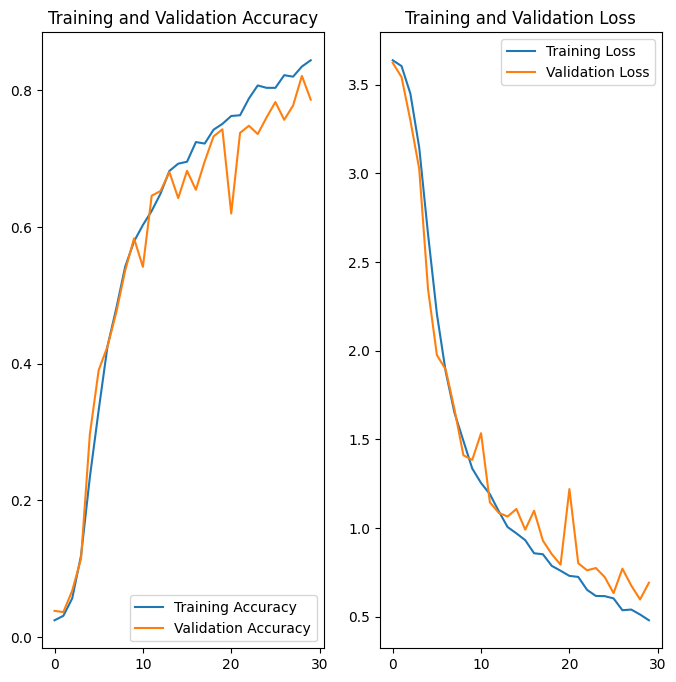

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Saving the Model

In [39]:
import os
#model_version = max([int(i) for i in (os.listdir("../models")+[0])]) + 1
#model.save(f"../models/{model_version}")
model.save('new_custom.keras')

Function for Inference

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Plotting the Inference Data

1/1 [==============================] - 0s 268ms/step


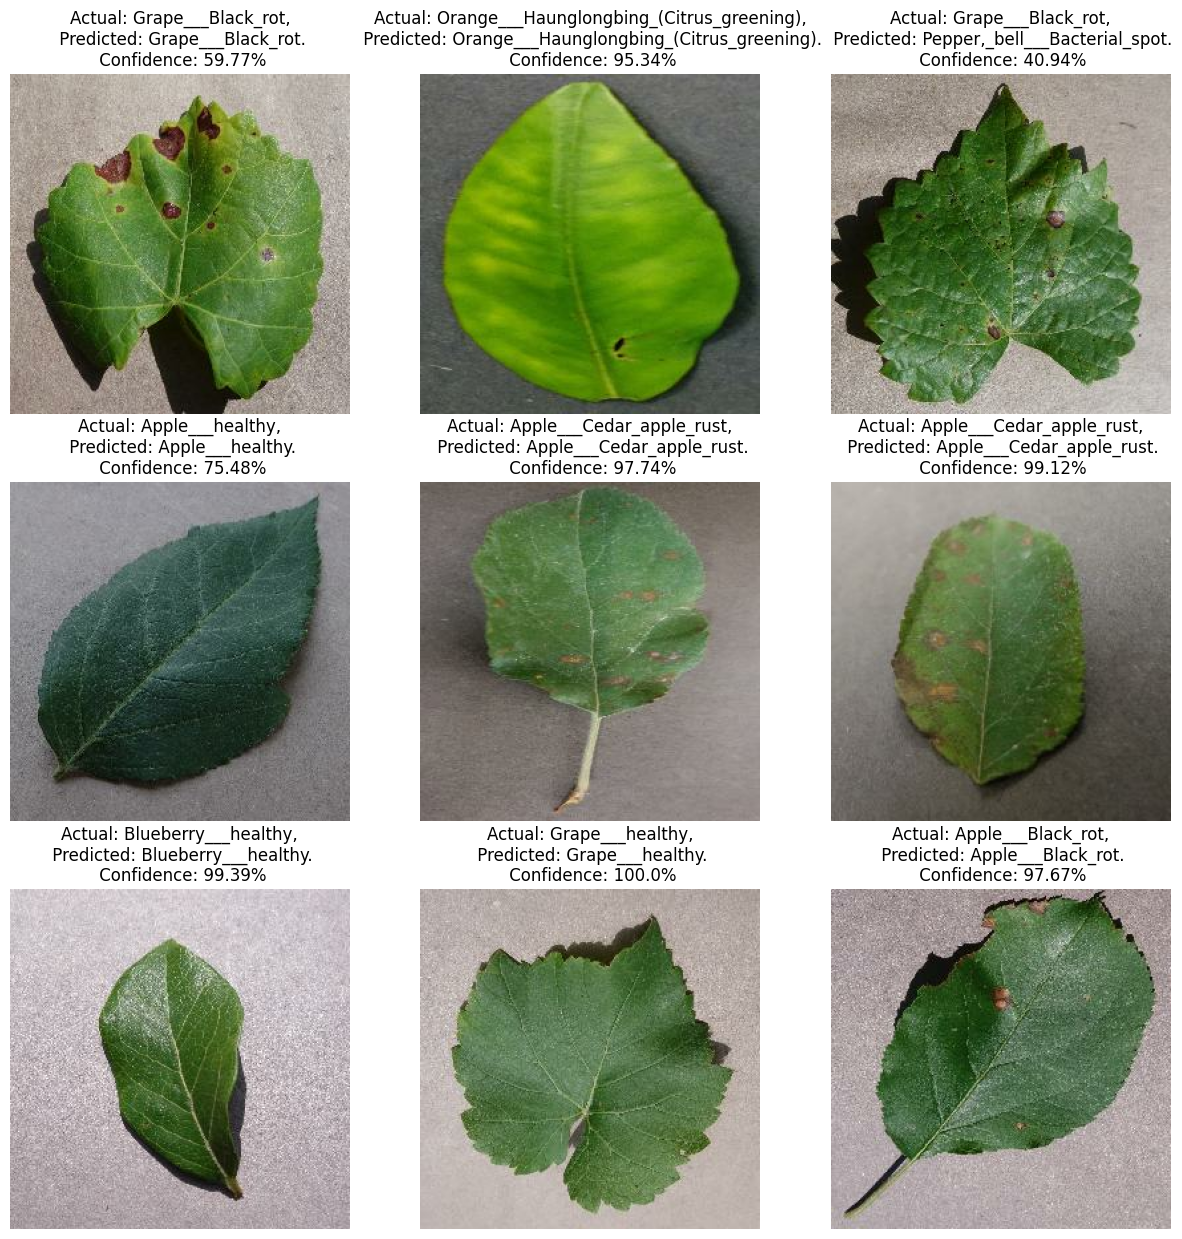

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = classes[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [1]:
import tensorflow as tf

# Load the Keras model
model = tf.keras.models.load_model('new_custom.h5')


In [2]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


INFO:tensorflow:Assets written to: C:\Users\Bishal\AppData\Local\Temp\tmprwr20qoj\assets


INFO:tensorflow:Assets written to: C:\Users\Bishal\AppData\Local\Temp\tmprwr20qoj\assets


In [4]:
# Save the TFLite model to a file
with open('new_custom.tflite', 'wb') as f:
    f.write(tflite_model)


<h1>Standalone code to use the trained model and seeing the result</h1>

<h2><---Redefining the functions from training part that are necessary to run the code below---></h2>

In [ ]:
#------------------------------------------------------------------------------------------------------------------------------#
import numpy as np
import os
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from torchvision.datasets import DatasetFolder
#------------------------------------------------------------------------------------------------------------------------------#
#                                                                                                                              #
#------------------------------------------------------------------------------------------------------------------------------#
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 30
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = r'' #path to the downloaded plantvillage dataset's color folder
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE
#------------------------------------------------------------------------------------------------------------------------------#
#                                                                                                                              #
#------------------------------------------------------------------------------------------------------------------------------#
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

#------------------------------------------------------------------------------------------------------------------------------#
#                                                                                                                              #
#------------------------------------------------------------------------------------------------------------------------------#
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
#------------------------------------------------------------------------------------------------------------------------------#
#                                                                                                                              #
#------------------------------------------------------------------------------------------------------------------------------#
# Call the find_classes method to get the classes and class-to-index mapping
classes, class_to_idx = DatasetFolder.find_classes(self=DatasetFolder,directory=data_dir)
n_classes = len(classes)
print(n_classes, classes)
#------------------------------------------------------------------------------------------------------------------------------#

Found 5738 files belonging to 38 classes.
38 ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites 

<h2>Testing the trained model</h2>

In [3]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='new_custom.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict(interpreter, img):
    # Preprocess the image to match input shape
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    img_array = np.array(img_array, dtype=np.float32)  # Ensure float32

    # Set the tensor to the first input of the interpreter
    interpreter.set_tensor(input_details[0]['index'], img_array)

    # Run inference
    interpreter.invoke()

    # Get the prediction
    predictions = interpreter.get_tensor(output_details[0]['index'])

    # Process the prediction to get the class and confidence
    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

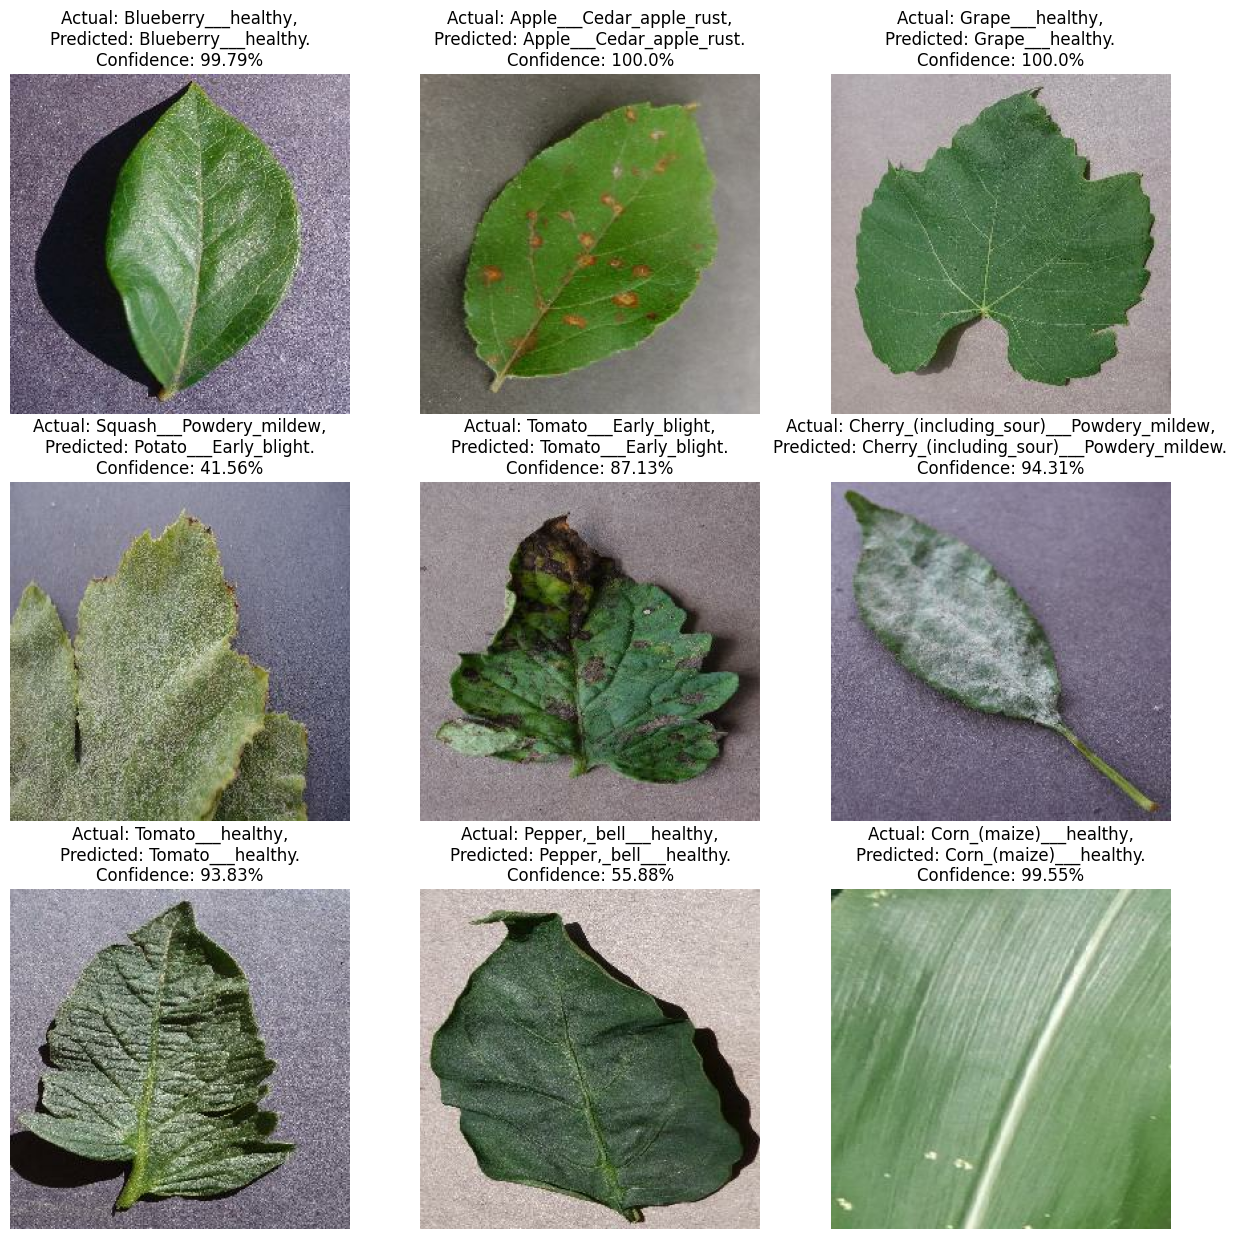

Designed and developed by pranoy71


In [4]:
# Visualize the predictions
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(interpreter, images[i].numpy())
        
        actual_class = classes[labels[i]] 
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")
        plt.axis("off")
plt.show()
print("Designed and developed by pranoy71")